<a href="https://colab.research.google.com/github/Moustaphaassajog/Classification_des_Panneaux_de_Signalisation/blob/main/Projet_Classification_des_Panneaux_de_Signalisation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Phase 1 : Préparation des données**

In [1]:

# ==================== IMPORTATION DES LIBRAIRIES ====================
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




In [2]:
#Préparation et vérification de données

# Chemins vers les données
TRAIN_PATH="/content/drive/MyDrive/archive_dataset_trafic/traffic_Data/DATA"
LABELS_CSV = "/content/drive/MyDrive/archive_dataset_trafic/labels.csv"
TEST_PATH = "/content/drive/MyDrive/archive_dataset_trafic/traffic_Data/TEST"

# Charger le CSV (optionnel, pour vérifier les labels)
labels_df = pd.read_csv(LABELS_CSV)
print("Labels disponibles dans le CSV :", labels_df.head())

# Vérifier le nombre de classes et le nombre d'images par classe
classes = os.listdir(TRAIN_PATH)
print(f"Nombre de classes : {len(classes)}\n")

for class_name in classes:
    class_path = os.path.join(TRAIN_PATH, class_name)
    if os.path.isdir(class_path):
        n_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg','.png','.jpeg'))])
        print(f"Classe {class_name} : {n_images} images")

# Vérifier la taille et le type des images
image_sizes = []
for class_name in classes[:5]:  # on teste sur 5 classes pour ne pas prendre trop de temps
    class_path = os.path.join(TRAIN_PATH, class_name)
    for img_name in os.listdir(class_path):
        if img_name.endswith(('.jpg','.png','.jpeg')):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                image_sizes.append(img.shape)  # (hauteur, largeur, canaux)

# Afficher quelques statistiques
image_sizes_set = set(image_sizes)
print("\nTailles uniques des images :", image_sizes_set)
print("Exemple d'une image :", image_sizes[0], "Type :", type(img))

Labels disponibles dans le CSV :    ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)
Nombre de classes : 58

Classe 9 : 2 images
Classe 57 : 6 images
Classe 6 : 78 images
Classe 7 : 152 images
Classe 56 : 110 images
Classe 8 : 8 images
Classe 52 : 36 images
Classe 54 : 324 images
Classe 53 : 2 images
Classe 55 : 162 images
Classe 51 : 8 images
Classe 50 : 56 images
Classe 49 : 42 images
Classe 5 : 194 images
Classe 44 : 30 images
Classe 47 : 12 images
Classe 43 : 82 images
Classe 46 : 18 images
Classe 48 : 10 images
Classe 45 : 24 images
Classe 42 : 32 images
Classe 41 : 18 images
Classe 37 : 58 images
Classe 40 : 32 images
Classe 4 : 98 images
Classe 38 : 30 images
Classe 35 : 156 images
Classe 39 : 34 images
Classe 34 : 26 images
Classe 36 : 40 images
Classe 33 : 4 images
Classe 31 : 42 images
Classe 30 : 150 images
Classe 3 : 260 images
Cl

## **Phase 2 : Prétraitement des données**

In [3]:

#Prétraitement de données (Redimensionnement et normalisation de données originale)

# ==================== PARAMÈTRES ====================
IMG_SIZE = (32, 32)  # taille finale des images pour le CNN

# ==================== FONCTION DE CHARGEMENT DES IMAGES ====================
def load_images_from_folder(folder_path, img_size=IMG_SIZE):
    """Charge les images d'un dossier structuré par classes"""
    X = []
    y = []
    classes = sorted(os.listdir(folder_path))
    print(f"Nombre de classes dans {folder_path} : {len(classes)}")

    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
            print(f"Classe {class_name} : {len(images)} images")
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(class_name)
    return np.array(X), np.array(y), classes

def load_test_images(folder_path, img_size=IMG_SIZE):
    """Charge les images de test sans labels"""
    X = []
    files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
    print(f"Nombre d'images dans {folder_path} : {len(files)}")
    for img_name in files:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            X.append(img)
    return np.array(X), files

# ==================== CHARGEMENT DES DONNÉES ====================
X_train, y_train, classes_train = load_images_from_folder(TRAIN_PATH)
X_test, test_files = load_test_images(TEST_PATH)

# ==================== NORMALISATION ====================
X_train = X_train / 255.0
X_test = X_test / 255.0

# ==================== AFFICHAGE ====================
print("\nExemple d'image après redimensionnement :", X_train[0].shape)
print("Type des images :", X_train[0].dtype)

print("\nDonnées prêtes pour le CNN :")
print("X_train :", X_train.shape, "y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("Exemples de fichiers test :", test_files[:5])

# ------------------- Préparer les labels -------------------
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # convertir en entiers
num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)

# Split train / validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_onehot,
    test_size=0.2,
    stratify=y_train_encoded,
    random_state=42
)


Nombre de classes dans /content/drive/MyDrive/archive_dataset_trafic/traffic_Data/DATA : 58
Classe 0 : 118 images
Classe 1 : 40 images
Classe 10 : 70 images
Classe 11 : 138 images
Classe 12 : 96 images
Classe 13 : 36 images
Classe 14 : 128 images
Classe 15 : 22 images
Classe 16 : 142 images
Classe 17 : 130 images
Classe 18 : 8 images
Classe 19 : 4 images
Classe 2 : 80 images
Classe 20 : 18 images
Classe 21 : 12 images
Classe 22 : 18 images
Classe 23 : 14 images
Classe 24 : 100 images
Classe 25 : 2 images
Classe 26 : 126 images
Classe 27 : 28 images
Classe 28 : 446 images
Classe 29 : 44 images
Classe 3 : 260 images
Classe 30 : 150 images
Classe 31 : 42 images
Classe 32 : 14 images
Classe 33 : 4 images
Classe 34 : 26 images
Classe 35 : 156 images
Classe 36 : 40 images
Classe 37 : 58 images
Classe 38 : 30 images
Classe 39 : 34 images
Classe 4 : 98 images
Classe 40 : 32 images
Classe 41 : 18 images
Classe 42 : 32 images
Classe 43 : 82 images
Classe 44 : 30 images
Classe 45 : 24 images
Clas

## **Phase 3 : Conception et entrainement du modèle**  

In [4]:

# ------------------- Créer le CNN -------------------
def create_cnn_model(input_shape=(32, 32, 3), num_classes=num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = create_cnn_model()
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------- Callbacks -------------------
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# ------------------- Entraînement -------------------
history = cnn_model.fit(
    X_train_split, y_train_split,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=cb,
    verbose=1
)

# ------------------- Prédiction sur le test set -------------------
y_pred_probs = cnn_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_pred_labels = le.inverse_transform(y_pred_classes)



Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.0952 - loss: 4.4340 - val_accuracy: 0.0540 - val_loss: 3.8211 - learning_rate: 0.0010
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.2622 - loss: 2.9417 - val_accuracy: 0.0624 - val_loss: 3.9330 - learning_rate: 0.0010
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - accuracy: 0.4043 - loss: 2.1623 - val_accuracy: 0.1559 - val_loss: 3.6219 - learning_rate: 0.0010
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - accuracy: 0.5118 - loss: 1.7175 - val_accuracy: 0.4820 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 289ms/step - accuracy: 0.6164 - loss: 1.2929 - val_accuracy: 0.7038 - val_loss: 0.9988 - learning_rate: 0.0010
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.6746 - loss: 1.1254 - val_accuracy: 0.7734 - val_loss: 0.8343 - learning_rate: 0.0010
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.7

## **Phase 4 : Évaluation des performances**

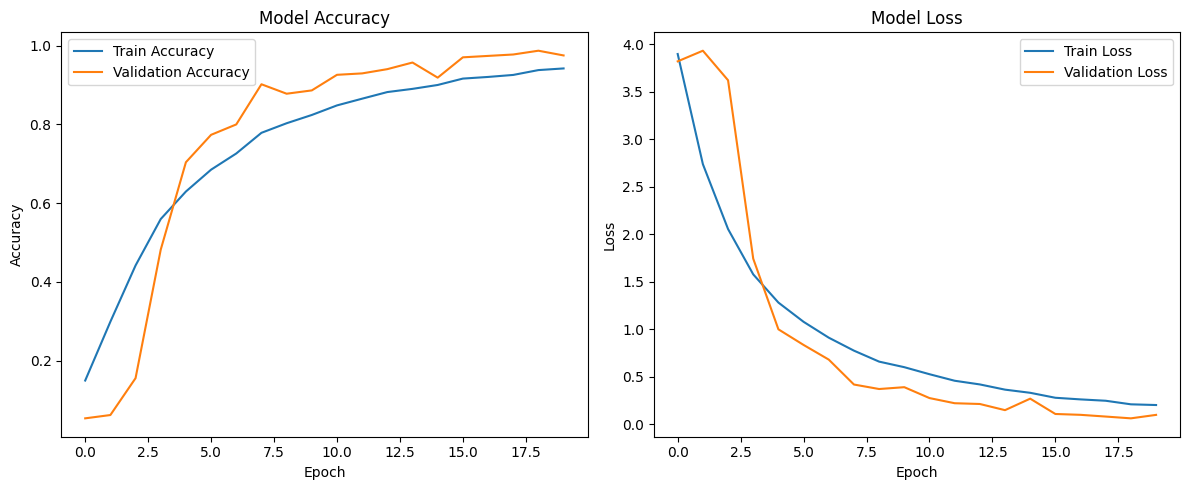

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step

Validation Accuracy : 98.68%


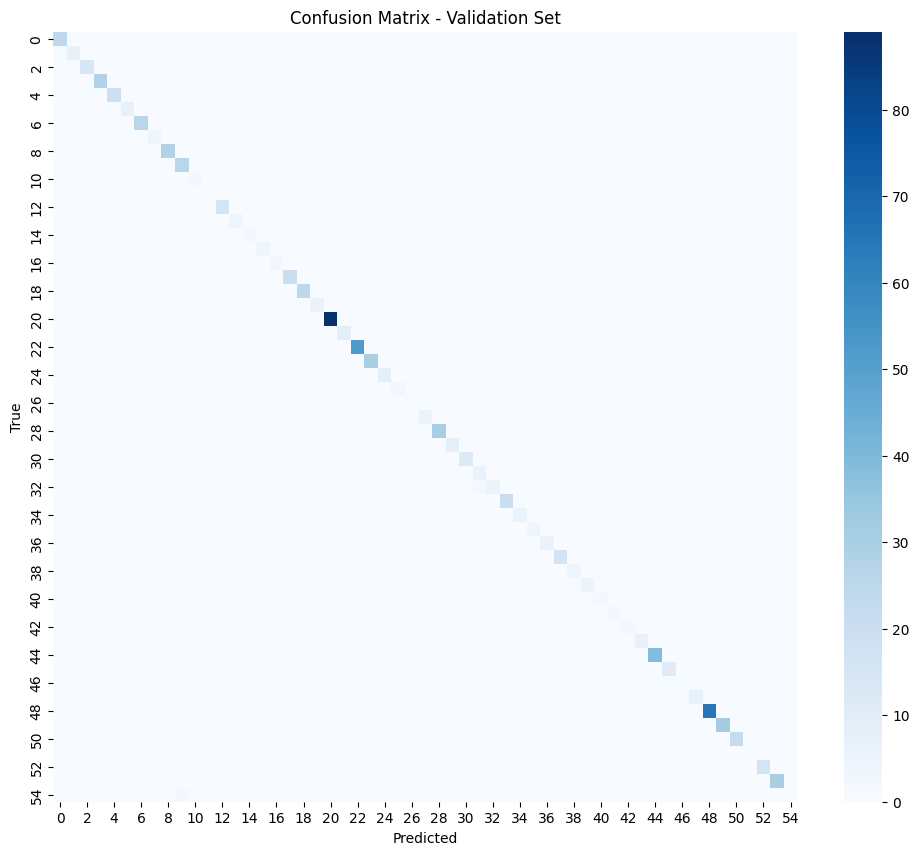

In [9]:

# ------------------- Accuracy -------------------

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# ------------------- Loss -------------------
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ------------------- Prédictions sur le set de validation -------------------

y_val_pred_probs = cnn_model.predict(X_val_split)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convertir y_val_split (one-hot) en labels entiers
y_val_true = np.argmax(y_val_split, axis=1)


# ------------------- Report Validation Accuracy -------------------
val_accuracy = accuracy_score(y_val_true, y_val_pred)
print(f"\nValidation Accuracy : {val_accuracy*100:.2f}%")

# ------------------- Matrice de Confusion -------------------
cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## **Phase 5 : Sauvegardes**

In [6]:
# Générer CSV pour le test set
test_files = sorted(os.listdir(TEST_PATH))
submission = pd.DataFrame({
    'filename': test_files,
    'predicted_class': y_pred_labels
})
submission.to_csv("traffic_sign_predictions.csv", index=False)
print("CSV de prédictions créé : traffic_sign_predictions.csv")

# ------------------- Sauvegarde du modèle -------------------
cnn_model.save('traffic_sign_cnn_model.h5')
print("Modèle CNN sauvegardé sous traffic_sign_cnn_model.h5")

CSV de prédictions créé : traffic_sign_predictions.csv
Modèle CNN sauvegardé sous traffic_sign_cnn_model.h5
